# NeuralTDA Plotting Routines

This purpose of this notebook is to create various plots of the results of topology computations on neural data

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pickle
import os
import sys
from ephys import core, events, rasters
from neuraltda import topology
import glob
import string
from scipy.io import wavfile
import scipy.signal as signal
from scipy.interpolate import interp1d
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

%pylab inline
reload(topology)

/Users/brad/anaconda/envs/neuraltda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


Populating the interactive namespace from numpy and matplotlib


<module 'neuraltda.topology' from '/Users/brad/GentnerLab/code/NeuralTDA/neuraltda/topology.pyc'>

# Load the data

Set 'block_path' to the path of the folder containing your post-manually sorted data

In [ ]:

block_path = '/Volumes/gentner/btheilma/experiments/B957/Pen01_Rgt_AP2500_ML1400__Site01_Z1535__B957_cat_P01_S01_Epc23-27/'
clusters   = core.load_clusters(block_path)
trials     = events.load_trials(block_path)
fs         = core.load_fs(block_path)
rec        = 0 

# Gather Topology Files

In [ ]:
topofolder_shuff = '/Volumes/gentner/btheilma/experiments/B957/Pen01_Rgt_AP2500_ML1400__Site01_Z1535__B957_cat_P01_S01_Epc23-27/topology/20161013T161853Z-25.0-4.0-permuted-shuffled/'
topofolder = '/Volumes/gentner/btheilma/experiments/B957/Pen01_Rgt_AP2500_ML1400__Site01_Z1535__B957_cat_P01_S01_Epc23-27/topology/20161013T161853Z-25.0-4.0-permuted/'

persistence_files = sorted(glob.glob(os.path.join(topofolder, '*.pkl')))
persistence_files_shuff = sorted(glob.glob(os.path.join(topofolder_shuff, '*.pkl')))

# Set Parameters for Plots

In [ ]:
bird=957
windt = 25
prd = 'stim'
nstim = 36
ntrials = 20
betti = 0
max_betti = 5
pen='01'
site='01'
plot_savepath = '/Volumes/gentner/btheilma/figures/'

# Single Betti - All Trials - All Stimuli



In [ ]:
tf = persistence_files[0]
tfilepath, tfilename = os.path.split(tf)
stimname = 'adad'
pdata = pickle.load(open(tf, 'r'))
pdata

In [ ]:
figsize = (22, 20)
fig, axs = plt.subplots(4, 4, figsize=figsize)

for stimind, tf in enumerate(persistence_files):
    tfilepath, tfilename = os.path.split(tf)
    stimname = list(string.ascii_lowercase)[stimind]
    pdata = pickle.load(open(tf, 'r'))
    
    ax = axs.flatten()[stimind]
    upper=0
    for trial in range(ntrials):     
        trialdata = pdata['{}'.format(str(trial))]
        betti1 = np.zeros([len(trialdata), 2])
        for ind, filt in enumerate(trialdata):
            
            betti1[ind, 0] = float((filt[0]))*(windt/1000.)
            try: 
                betti1[ind, 1] = float(filt[1][betti])
            except IndexError:
                betti1[ind, 1] = 0
            
        upper = max([upper, max(betti1[:, 1])])
        #print(upper)
        
        #ax.set_xlim(0, 8)
        #ax.set_ylim(0, 10)
        pltcolor='b'
#        if stimname in ['stimA', 'stimB', 'stimC', 'stimD']:
#            pltcolor = 'r'
        ax.plot(betti1[:, 0], betti1[:,1], pltcolor, lw=2)
        ax.set_title('Stimulus: {}'.format(stimname))
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Betti Number Value')
        ax.set_ylim([0, upper+1])
plt.savefig(plot_savepath+'B{}_betti{}_timedep_{}ms_{}.png'.format(bird, betti, windt, prd))

In [ ]:
topofolder1 = '/mnt/cube/btheilma/experiments/B1235/phy051316/Pen01_Lft_AP200_ML800__Site01_Z2200__B1235_cat_P01_S01_1/topology/bht060716/B1235_cat_P01_S01_1-good_50ms_stim/'
topofolder2 = '/mnt/cube/btheilma/experiments/B1235/phy051316/Pen01_Lft_AP200_ML800__Site01_Z2200__B1235_cat_P01_S01_1/topology/bht060816/B1235_cat_P01_S01_1-good_50ms_stim/'
persistence_files1 = glob.glob(os.path.join(topofolder1, '*.pkl'))
persistence_files2 = glob.glob(os.path.join(topofolder2, '*.pkl'))
tfile1 = persistence_files1[0]
tfile2 = persistence_files2[0]
print(persistence_files1)
print(persistence_files2)

# Single Betti - Trial Average - All Stimuli

Uses step interpolation

In [ ]:
from scipy.interpolate import interp1d
t = np.linspace(0, 7, num=1000)
betticurves = np.zeros((ntrials, 1000))
bettiStimspline=[]
figsize = (22, 20)
fig, axs = plt.subplots(4, 4, figsize=figsize)


for stimind in range(len(persistence_files)):
    tf = persistence_files[stimind]
    tfilepath, tfilename = os.path.split(tf)
    stimname = list(string.ascii_lowercase)[stimind]
    pdata = pickle.load(open(tf, 'r'))
    #print(tf)
    upper=0
    bettiTrialspline=[]
    ax = axs.flatten()[stimind]
    for trial in range(20):
        
        trialdata = pdata['{}'.format(str(trial))]
        betti1 = np.zeros([len(trialdata), 2])
        for ind, filt in enumerate(trialdata):
            betti1[ind, 0] = filt[0]*windt/1000.
            try: 
                betti1[ind, 1] = filt[1][betti]
            except IndexError:
                betti1[ind, 1] = 0
                
        bettifunc = interp1d(betti1[:, 0], betti1[:, 1], kind='zero', bounds_error=False, fill_value=(betti1[0, 1], betti1[-1, 1]))
        betticurve = bettifunc(t)
        betticurves[trial, :] = betticurve
    avgbetticurve = np.mean(betticurves, axis=0)
    ax.plot(t, avgbetticurve, lw=2)
    ax.set_title('Stimulus: {}'.format(stimname))
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Betti Number Value')
   

# All Betti Numbers - Trial Average - Single Stimulus

In [ ]:

t = np.linspace(0, 7, num=1000)
betticurves = np.zeros((max_betti, ntrials, 1000))
bettiStimspline=[]

stimind = 15
tf = persistence_files[stimind]
tfilepath, tfilename = os.path.split(tf)
stimname = list(string.ascii_lowercase)[stimind]
pdata = pickle.load(open(tf, 'r'))

for trial in range(20): 
    trialdata = pdata['{}'.format(str(trial))]
    for betti_num in range(max_betti):
        betti1 = np.zeros([len(trialdata), 2])
        for ind, filt in enumerate(trialdata):
            betti1[ind, 0] = filt[0]*windt/1000.
            try: 
                betti1[ind, 1] = filt[1][betti_num]
            except IndexError:
                betti1[ind, 1] = 0
                
        bettifunc = interp1d(betti1[:, 0], betti1[:, 1], kind='zero', bounds_error=False, fill_value=(betti1[0, 1], betti1[-1, 1]))
        betticurve = bettifunc(t)
        betticurves[betti_num, trial, :] = betticurve
        
avgbetticurve = np.mean(betticurves, axis=1)

In [ ]:
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'36', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'36'}

figsize = (22, 22)
fig = plt.figure(figsize=figsize)

ax = plt.subplot() # Defines ax variable by creating an empty plot

# Set the tick labels font
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(32)

plt.plot(t, avgbetticurve[0, :], t, avgbetticurve[1, :], t, avgbetticurve[2, :], t, avgbetticurve[3, :], lw=6)
plt.title('Stimulus: {}'.format(stimname), **title_font)
plt.xlabel('Time (seconds)', **axis_font)
plt.ylabel('Betti Number Value', **axis_font)

plt.legend(['Betti 0', 'Betti 1', 'Betti 2', 'Betti 3'], fontsize=36, loc=2)
plt.savefig('/home/brad/topology_figs/for_neurodinner/test.png')

# All Bettis - Trial Average - Single Stimulus - Plot with Stimulus Spectrogram

## Compute 

In [ ]:
stimind = 15
stimulus_file = '/home/brad/P_40k_warp.wav'

rate, song = wavfile.read('/home/brad/P_40k_warp.wav')
sf, st, sPxx = signal.spectrogram(song, rate)
plt.figure()
plt.imshow(np.log(sPxx), origin='lower', extent=[st[0], st[-1], sf[0], sf[-1]], aspect='auto')

from scipy.interpolate import interp1d

betticurves = np.zeros((max_betti, ntrials, len(st)))
bettiStimspline=[]

tf = persistence_files[stimind]
tfilepath, tfilename = os.path.split(tf)
stimname = list(string.ascii_lowercase)[stimind]
pdata = pickle.load(open(tf, 'r'))

for trial in range(ntrials):
        
    trialdata = pdata['{}'.format(str(trial))]
    for betti_num in range(max_betti):
        betti1 = np.zeros([len(trialdata), 2])
        for ind, filt in enumerate(trialdata):
            betti1[ind, 0] = filt[0]*windt/1000.
            try: 
                betti1[ind, 1] = filt[1][betti_num]
            except IndexError:
                betti1[ind, 1] = 0
                
        bettifunc = interp1d(betti1[:, 0], betti1[:, 1], kind='zero', bounds_error=False, fill_value=(betti1[0, 1], betti1[-1, 1]))
        betticurve = bettifunc(st)
        betticurves[betti_num, trial, :] = betticurve
        
avgbetticurve = np.mean(betticurves, axis=1)

## Plot

In [ ]:
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'36', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'36'}

figsize = (22, 22)
f, pltaxes = plt.subplots(2, 1, figsize=(22,18), sharex=True)
ax = pltaxes[0]
# Set the tick labels font
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(32)
    
song_spec_normed = sPxx / np.max(sPxx)
ax.imshow(np.log(song_spec_normed), origin='lower', extent=[st[0], st[-1], sf[0], sf[-1]], aspect='auto', cmap='spectral')
ax.set_ylabel('Frequency (Hz)', **axis_font)

ax=pltaxes[1]
# Set the tick labels font
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(32)

ax.plot(st, avgbetticurve[0, :], st, avgbetticurve[1, :], st, avgbetticurve[2, :], st, avgbetticurve[3, :], lw=6)
ax.set_title('Stimulus: {}'.format(stimname), **title_font)
ax.set_xlabel('Time (seconds)', **axis_font)
ax.set_ylabel('Betti Number Value', **axis_font)
ax.set_xlim([st[0], st[-1]])

#plt.legend(['Betti 0', 'Betti 1', 'Betti 2', 'Betti 3'], fontsize=36, loc=2)
plt.savefig('/home/brad/topology_figs/for_neurodinner/B1235_P01S01_StimP_AllAvgBetti_withSpectrogram.png')

# All Betti Numbers - Trial Averages - All Stimuli

In [ ]:

t = np.linspace(0, 7, num=1000)
betticurves = np.zeros((max_betti, ntrials, 1000))
bettiStimspline=[]
figsize = (11, 11)
figsize = (22, 20)
fig, axs = plt.subplots(4, 4, figsize=figsize)

for stimind in range(nstim):
    tf = persistence_files[stimind]
    tfilepath, tfilename = os.path.split(tf)
    stimname = list(string.ascii_lowercase)[stimind]
    pdata = pickle.load(open(tf, 'r'))
    ax = axs.flatten()[stimind]
    for trial in range(ntrials):
        
        trialdata = pdata['{}'.format(str(trial))]
        for betti_num in range(max_betti):
            betti1 = np.zeros([len(trialdata), 2])
            for ind, filt in enumerate(trialdata):
                betti1[ind, 0] = filt[0]*windt/1000.
                try: 
                    betti1[ind, 1] = filt[1][betti_num]
                except IndexError:
                    betti1[ind, 1] = 0
                
            bettifunc = interp1d(betti1[:, 0], betti1[:, 1], kind='zero', bounds_error=False, fill_value=(betti1[0, 1], betti1[-1, 1]))
            betticurve = bettifunc(t)
            betticurves[betti_num, trial, :] = betticurve
        
    avgbetticurve = np.mean(betticurves, axis=1)

    ax.plot(t, avgbetticurve[0, :], t, avgbetticurve[1, :], t, avgbetticurve[2, :], t, avgbetticurve[3, :], lw=3)
    ax.set_title('Stimulus: {}'.format(stimname))
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Betti Number Value')
    ax.set_ylim([0, 14])
plt.savefig('/home/brad/B{}_P{}S{}_avgbettis_timedep_{}ms_{}.png'.format(bird, pen, site, windt, prd))

# All Betti Numbers - (Trial Averages + Single Trials) - One Stimulus


In [ ]:

t = np.linspace(0, 7, num=1000)

betticurves = np.zeros((max_betti, ntrials, 1000))
bettiStimspline=[]


stimind = 13
tf = persistence_files[stimind]
tfilepath, tfilename = os.path.split(tf)
stimname = list(string.ascii_lowercase)[stimind]
pdata = pickle.load(open(tf, 'r'))

for trial in range(20):
        
    trialdata = pdata['{}'.format(str(trial))]
    for betti_num in range(max_betti):
        betti1 = np.zeros([len(trialdata), 2])
        for ind, filt in enumerate(trialdata):
            betti1[ind, 0] = filt[0]*windt/1000.
            try: 
                betti1[ind, 1] = filt[1][betti_num]
            except IndexError:
                betti1[ind, 1] = 0
                
        bettifunc = interp1d(betti1[:, 0], betti1[:, 1], kind='zero', bounds_error=False, fill_value=(betti1[0, 1], betti1[-1, 1]))
        betticurve = bettifunc(t)
        betticurves[betti_num, trial, :] = betticurve
avgbetticurve = np.mean(betticurves, axis=1)


In [ ]:
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'36', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'36'}

figsize = (22, 20)
fig, axs = plt.subplots(2, 2, figsize=figsize)

for bettinum in range(max_betti):
    ax = axs.flatten()[bettinum]

    # Set the tick labels font
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(32)
    for trial in range(20):
        ax.plot(t, betticurves[bettinum, trial, :], 'b', lw=4)
        ax.set_title('Betti Number: {}'.format(bettinum), **title_font)
        #ax.set_xlabel('Time (seconds)', **axis_font)
        #ax.set_ylabel('Betti Number Value', **axis_font)
        ax.set_ylim([0, 16])
    ax.plot(t, avgbetticurve[bettinum, :], 'r', lw=6)
plt.savefig('/home/brad/topology_figs/for_neurodinner/B1235_P01S01_Stim13_AllBettis_TrialbyTrial.png')

# Single Betti - All Trials - All Permutations - All Stimuli

In [ ]:
def plot_betti_trace_recursive(trialdata, ax, upper):
    
    if type(trialdata) is dict:
        for permnum, perm in enumerate(trialdata.keys()):
            new_trialdata = trialdata[perm]
            new_upper=plot_betti_trace_recursive(new_trialdata, ax, upper)
            upper = new_upper
        return upper
    else:
        betti1 = np.zeros([len(trialdata), 2])
        for ind, filt in enumerate(trialdata):
            betti1[ind, 0] = filt[0]*(windt/1000.)
            try: 
                betti1[ind, 1] = filt[1][betti]
            except IndexError:
                betti1[ind, 1] = 0
            
        upper = max([upper, max(betti1[:, 1])])
        pltcolor='b'
        ax.plot(betti1[:, 0], betti1[:,1], pltcolor, lw=2)
        ax.set_title('Stimulus: {}'.format(stimname))
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Betti Number Value')
        ax.set_ylim([0, upper+1])
        return upper


In [ ]:

figsize = (22, 20)
fig, axs = plt.subplots(4, 4, figsize=figsize)

for stimind in range(len(persistence_files)):
    tf = persistence_files[stimind]
    tfilepath, tfilename = os.path.split(tf)
    stimname = list(string.ascii_lowercase)[stimind]
    pdata = pickle.load(open(tf, 'r'))
    ax = axs.flatten()[stimind]
    upper=0
    lns=0
    plot_betti_trace_recursive(pdata, ax, upper)
plt.savefig(plot_savepath+'B{}_betti{}_{}ms_{}_permuted_shuffled.png'.format(bird, betti, windt, prd))    

In [ ]:

figsize = (22, 20)
fig, axs = plt.subplots(4, 4, figsize=figsize)

for stimind in range(len(persistence_files)):
    tf = persistence_files[stimind]
    tfilepath, tfilename = os.path.split(tf)
    stimname = list(string.ascii_lowercase)[stimind]
    pdata = pickle.load(open(tf, 'r'))
    ax = axs.flatten()[stimind]
    upper=0
    lns=0
    for trial in range(ntrials):     
        trialdata = pdata['{}'.format(str(trial))]
        for permnum, perm in enumerate(trialdata.keys()):
            permdata = trialdata['{}'.format(perm)]
            betti1 = np.zeros([len(permdata), 2])
            for ind, filt in enumerate(permdata):
                betti1[ind, 0] = filt[0]*(windt/1000.)
                try: 
                    betti1[ind, 1] = filt[1][betti]
                except IndexError:
                    betti1[ind, 1] = 0
            
            upper = max([upper, max(betti1[:, 1])])
            #print(upper)
        
            #ax.set_xlim(0, 8)
            #ax.set_ylim(0, 10)
            pltcolor='b'
#        if stimname in ['stimA', 'stimB', 'stimC', 'stimD']:
#            pltcolor = 'r'
            ax.plot(betti1[:, 0], betti1[:,1], pltcolor, lw=2)
            lns = lns+1
            ax.set_title('Stimulus: {}'.format(stimname))
            ax.set_xlabel('Time (seconds)')
            ax.set_ylabel('Betti Number Value')
            ax.set_ylim([0, upper+1])
print(lns)
plt.savefig(plot_savepath+'B{}_betti{}_{}ms_{}_permuted.png'.format(bird, betti, windt, prd))

In [ ]:
from scipy.interpolate import interp1d
def compute_avg_betti_recursive(bettidata, betticurves, t):
    
    if type(bettidata) is dict:
        for permnum, perm in enumerate(bettidata.keys()):
            betticurves = compute_avg_betti_recursive(bettidata[perm], betticurves, t)
        return betticurves
    else:
        betti1 = np.zeros([len(bettidata), 2])
        for ind, filt in enumerate(bettidata):
            betti1[ind, 0] = filt[0]*windt/1000.
            try: 
                betti1[ind, 1] = filt[1][betti]
            except IndexError:
                betti1[ind, 1] = 0
                
        bettifunc = interp1d(betti1[:, 0], betti1[:, 1], kind='zero', bounds_error=False, fill_value=(betti1[0, 1], betti1[-1, 1]))
        betticurve = bettifunc(t)
        betticurves = np.vstack((betticurves, betticurve))
        return betticurves

In [ ]:
t = np.linspace(0, 7, num=1000)
betticurves = np.zeros((ntrials, 1000))
bettiStimspline=[]
figsize = (22, 20)
fig, axs = plt.subplots(4, 4, figsize=figsize)


for stimind in range(len(persistence_files)):
    tf = persistence_files[stimind]
    print(tf)
    tfilepath, tfilename = os.path.split(tf)
    stimname = list(string.ascii_lowercase)[stimind]
    pdata = pickle.load(open(tf, 'r'))
    upper=0
    bettiTrialspline=[]
    ax = axs.flatten()[stimind]
    betticurves = np.empty_like(t)
    betticurves = compute_avg_betti_recursive(pdata, betticurves, t)
    print(betticurves.shape)
    avgbetticurve = np.mean(betticurves[1:], axis=0)
    ax.plot(t, avgbetticurve, lw=2)
    ax.set_title('Stimulus: {}'.format(stimname))
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Betti Number Value')
plt.savefig(plot_savepath+'B{}_betti{}_{}ms_{}_permuted_average.png'.format(bird, betti, windt, prd))

In [ ]:
t = np.linspace(0, 7, num=1000)
betticurves = np.zeros((ntrials, 1000))
bettiStimspline=[]
figsize = (24, 20)
fig, axs = plt.subplots(2, 4, figsize=figsize)


for stimind in range(len(persistence_files)):
    tf = persistence_files[stimind]
    tf_shuff = persistence_files_shuff[stimind]
    print(tf)
    tfilepath, tfilename = os.path.split(tf)
    tfilepath, tfilename_shuff = os.path.split(tf_shuff)
    stimname = list(string.ascii_lowercase)[stimind]
    pdata = pickle.load(open(tf, 'r'))
    pdata_shuff = pickle.load(open(tf_shuff, 'r'))
    upper=0
    bettiTrialspline=[]
    ax = axs.flatten()[stimind]
    betticurves = np.empty_like(t)
    betticurves = compute_avg_betti_recursive(pdata, betticurves, t)
    print(betticurves.shape)
    avgbetticurve = np.mean(betticurves[1:], axis=0)
    
    bc_shuff = np.empty_like(t)
    bc_shuff = compute_avg_betti_recursive(pdata_shuff, bc_shuff, t)
    avgbcshuff = np.mean(bc_shuff[1:], axis=0)
    
    ax.plot(t, avgbetticurve-avgbcshuff, lw=2)
    ax.set_title('Stimulus: {}'.format(stimname))
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Betti Number Value')
plt.savefig(plot_savepath+'B{}_betti{}_{}ms_{}_permuted_average_difference.png'.format(bird, betti, windt, prd))

In [ ]:
t = np.linspace(0, 7, num=1000)
betticurves = np.zeros((ntrials, 1000))
bettiStimspline=[]
figsize = (24, 20)
fig, axs = plt.subplots(2, 4, figsize=figsize)


for stimind in range(len(persistence_files)):
    tf = persistence_files[stimind]
    tf_shuff = persistence_files_shuff[stimind]
    print(tf)
    tfilepath, tfilename = os.path.split(tf)
    tfilepath, tfilename_shuff = os.path.split(tf_shuff)
    stimname = list(string.ascii_lowercase)[stimind]
    pdata = pickle.load(open(tf, 'r'))
    pdata_shuff = pickle.load(open(tf_shuff, 'r'))
    upper=0
    bettiTrialspline=[]
    ax = axs.flatten()[stimind]
    betticurves = np.empty_like(t)
    betticurves = compute_avg_betti_recursive(pdata, betticurves, t)
    print(betticurves.shape)
    avgbetticurve = np.mean(betticurves[1:], axis=0)
    
    bc_shuff = np.empty_like(t)
    bc_shuff = compute_avg_betti_recursive(pdata_shuff, bc_shuff, t)
    avgbcshuff = np.mean(bc_shuff[1:], axis=0)
    
    ax.plot(t, avgbetticurve, 'r',lw=2)
    ax.plot(t, avgbcshuff, 'b', lw=2)
    ax.set_title('Stimulus: {}'.format(stimname))
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Betti Number Value')
plt.savefig(plot_savepath+'B{}_betti{}_{}ms_{}_permuted_average_wshuffd.png'.format(bird, betti, windt, prd))

# Plotting from Master Results Dictionary

In [2]:
resFname = '/Volumes/gentner/btheilma/experiments/B957/Pen01_Rgt_AP2500_ML1400__Site01_Z1535__B957_cat_P01_S01_Epc23-27/20161013T161853Z-25.0-4.0-masterResults.pkl'
resFname = '/Volumes/gentner/btheilma/experiments/B1101/Pen01_Lft_AP2500_ML750__Site04_Z2300__B1101_cat_P01_S04_3/20161028T001530Z-25.0-4.0-masterResults.pkl'
with open(resFname, 'r') as f:
    mrDict = pickle.load(f)

In [14]:
computationClass = 'permuted'
results = mrDict[computationClass]
resultsSh = mrDict['permuted-shuffled']
stims = results.keys()

In [10]:
maxt = 100
def plotBarcodeRecursive(resDict):
    
    if 'barcodes' in resDict.keys():
        barcodeDat = resDict['barcodes']
        bettis = barcodeDat.keys()
        for betti in bettis:
            bettiBarcode = barcodeDat[betti]
            nlines = len(bettiBarcode)
            ycoords = [[s,s] for s in range(nlines)]
            xcoords = [[s[0], s[1]+maxt*(s[1] < 0)] for s in bettiBarcode]
            fig = plt.figure()
            plt.plot(np.transpose(xcoords), np.transpose(ycoords))
            plt.title('Hstr: %s  Betti: %s' % (resDict['hstr'], betti))
            plt.show()
    else:
        for ind, k in enumerate(resDict.keys()):
            plotBarcodeRecursive(resDict[k])


def plotBettiCurveRecursive(resDict):
    
    if 'bettis' in resDict.keys():
        bettiDat = resDict['bettis']
        bettis = len(bettiDat[0][1])
        for betti in range(bettis):
            ycoords = [s[1][betti] for s in bettiDat]
            xcoords = [s[0] for s in bettiDat]
            fig = plt.figure()
            plt.plot(np.transpose(xcoords), np.transpose(ycoords))
            plt.title('Hstr: %s  Betti: %s' % (resDict['hstr'], betti))
            plt.show()
    else:
        for ind, k in enumerate(resDict.keys()):
            plotBettiCurveRecursive(resDict[k])
            
def avgBettiRecursive(bettiDict, bettinum, runningSum, N, maxT, windt):
    if 'bettis' in bettiDict.keys():
        bettiT = np.array([s[0] for s in bettiDict['bettis']])*(windt/1000.)
        maxT = max(bettiT)
        try:
            bettiB = np.array([s[1][bettinum] for s in bettiDict['bettis']])
        except:
            
            bettiB = np.zeros(len(bettiT))
        bfunc = interp1d(bettiT, bettiB, kind='zero', bounds_error=False, fill_value=(bettiB[0], bettiB[-1]))
        t = np.linspace(0, maxT, 1000)
        bvals = bfunc(t)
        return (runningSum + bvals, N+1, maxT)
    else:
        for k in bettiDict.keys():
            runningSum, N, maxT = avgBettiRecursive(bettiDict[k], bettinum, runningSum, N, maxT, windt)
        return (runningSum, N, maxT)
    
def computeAvgBettiCurve(resDict, stim, betti, windt):
    
    stimdata = resDict[stim]
    
    runningSum, N, maxT = avgBettiRecursive(stimdata, betti, np.zeros(1000), 0, 0, windt)
    avgBetti = runningSum / float(N)
    t = np.linspace(0, maxT, len(avgBetti))
    
    return (avgBetti, t, maxT)
    
def plotAvgBettiCurves(avgBetti, t, betti, stim): 
    plt.figure()
    plt.plot(t, avgBetti)
    plt.title('Stim: %s Betti: %d' %(stim, betti))
    plt.ylim([0, max(avgBetti)+2])
    plt.xlim([0, max(t)])
    plt.show()
def plotStimAvgMinusTotalAvg(resDict, stim, betti):
    stimdata = resDict[stim]
    t = np.linspace(0, 2, 1000)
    runningSum, N = avgBettiRecursive(stimdata, betti, np.zeros(len(t)), 0, t)
    avgBetti = runningSum / float(N)
    
    totAvg, N = avgBettiRecursive(resDict, betti, np.zeros(len(t)), 0, t)
    totAvg = totAvg/float(N)
    
    
    plt.figure(figsize=(11, 8))
    plt.plot(t, avgBetti-totAvg)
    sns.despine()
    plt.title('Stim: %s Betti: %d' %(stim, betti))
    plt.ylim([-5, 5])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Difference')
    plt.savefig('B957P01S01-Stim_{}-Betti_{}.png'.format(stim, betti))
    plt.show()
    
    
def plotEvidenceAverageBettiDifference(resDict, betti):
    
    maxt = 1000
    evRunningSum = np.zeros((7, maxt))
    evN = np.zeros(7)
    
    for stim in resDict.keys():
        ev = computeEvidence(stim)
        stimdata = resDict[stim]
        t = np.linspace(0, 2, maxt)
        runningSum, N = avgBettiRecursive(stimdata, betti, np.zeros(len(t)), 0, t)
        avgBetti = runningSum / float(N)
    
        totAvg, N = avgBettiRecursive(resDict, betti, np.zeros(len(t)), 0, t)
        totAvg = totAvg/float(N)
    
        diff = avgBetti - totAvg
        evRunningSum[ev+3, :] = evRunningSum[ev+3, :] + diff
        evN[ev+3] = evN[ev+3] +1

    for n in range(7):
        evRunningSum[n, :] = evRunningSum[n, :] / float(evN[n])
        plt.figure(figsize=(11, 8))
        plt.plot(t, evRunningSum[n, :])
        sns.despine()
        plt.title('Evidence: %d Betti: %d' %(n-3, betti))
        plt.ylim([-5, 5])
        plt.xlabel('Time (seconds)')
        plt.ylabel('Difference')
        plt.savefig('B957P01S01-Evidence_{}-Betti_{}.png'.format(n-3, betti))
        plt.show()


In [ ]:
evidences = {'ad':1, 'ae': -1, 'de': 1, 'ed': -1, 'ea': 1, 'da':-1}
def computeEvidence(stim):
    ev = 0
    nMotifs = len(stim)
    for n in range(nMotifs-1):
        transition = stim[n:n+2]
        ev = ev+evidences[transition]
    return ev


In [ ]:
trials['evidence'] = trials.apply(lambda row: computeEvidence(row['stimulus']), axis=1)
trials.head()

In [13]:
maxT

0.40000000000000002

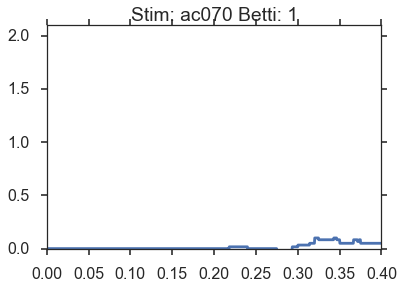

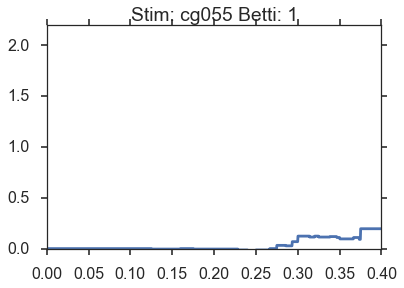

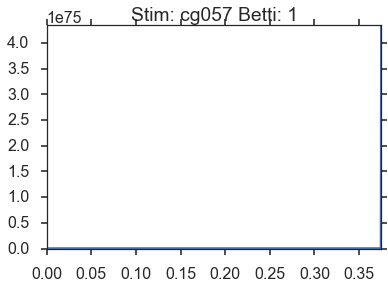

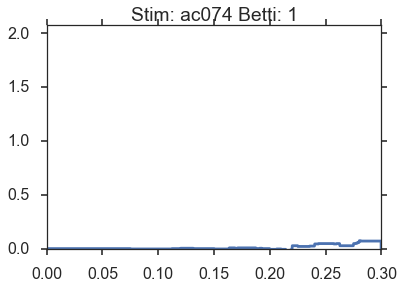

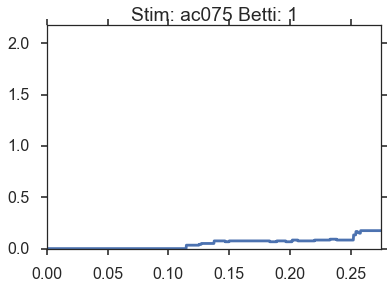

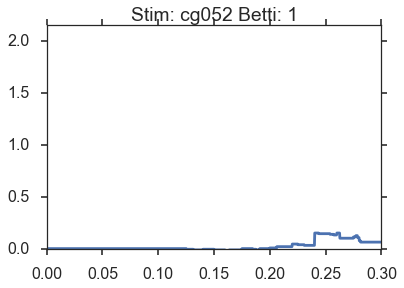

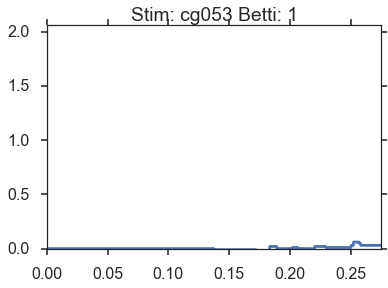

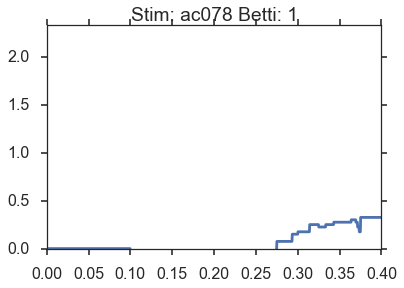

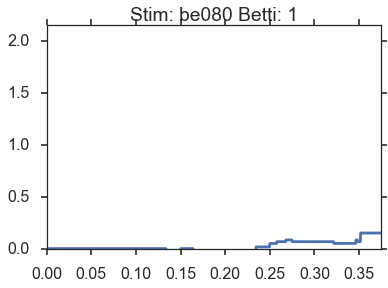

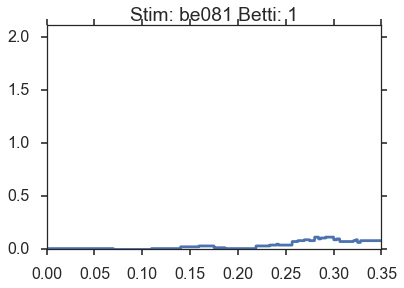

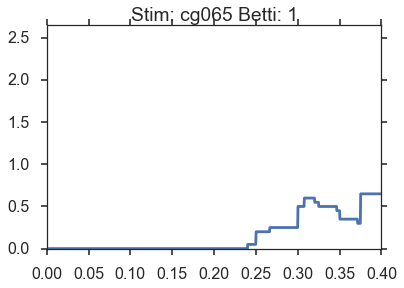

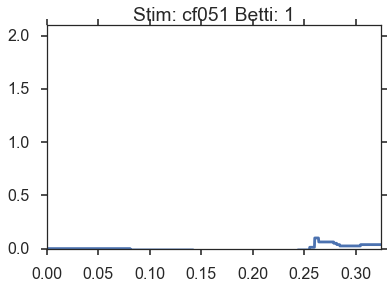

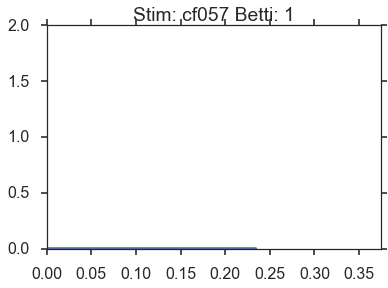

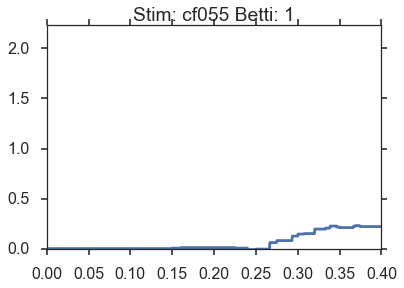

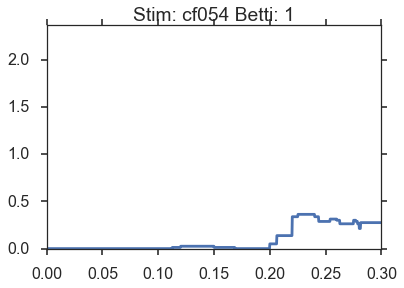

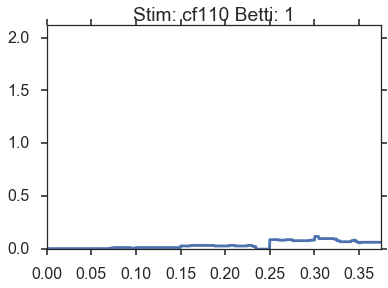

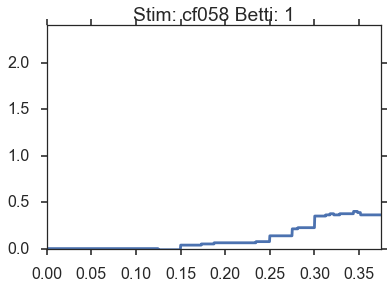

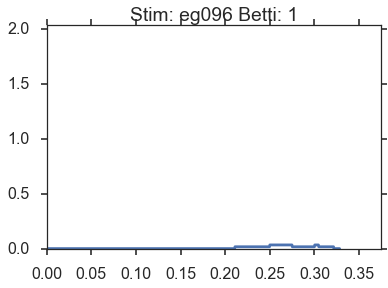

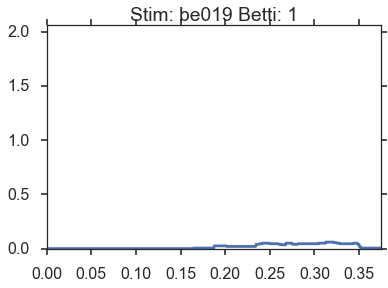

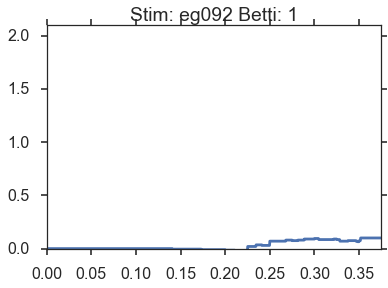

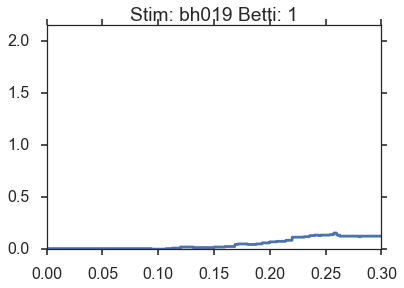

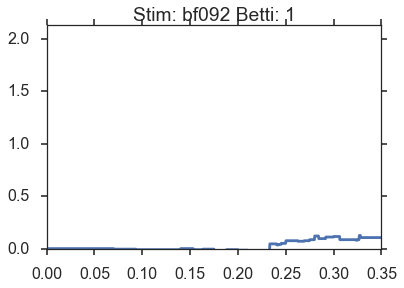

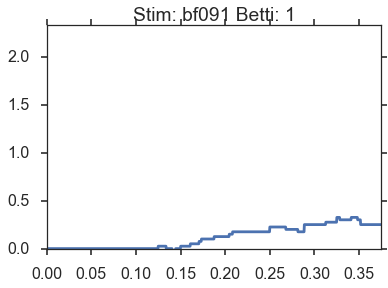

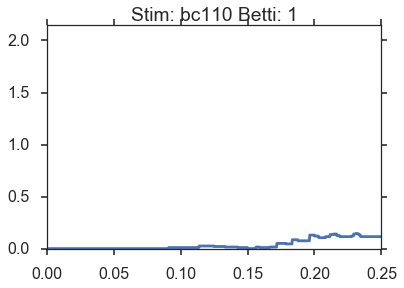

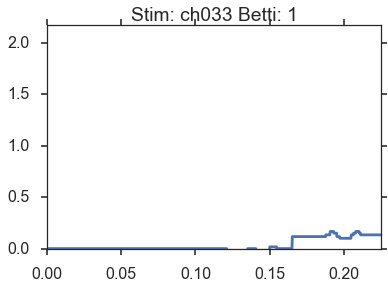

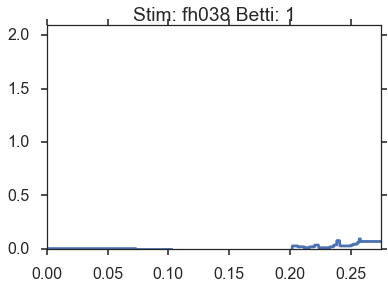

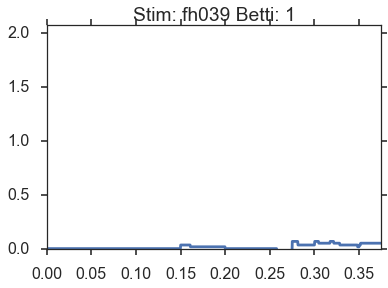

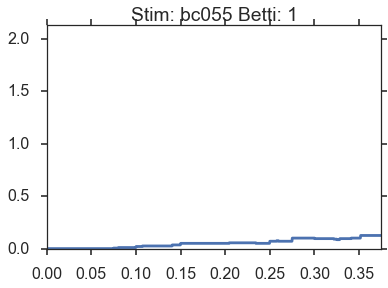

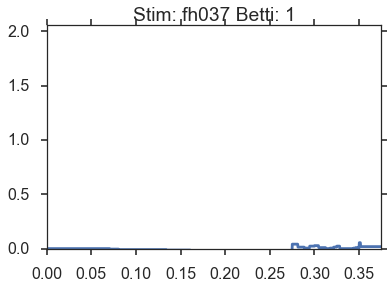

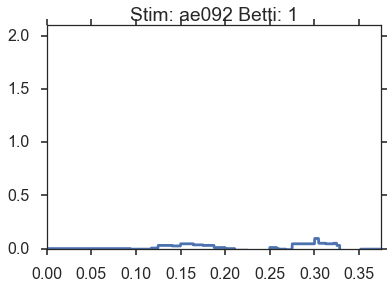

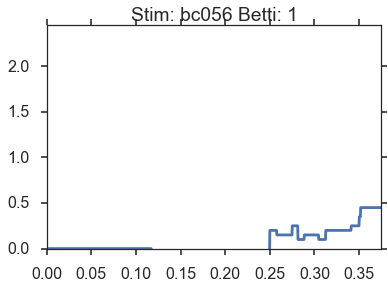

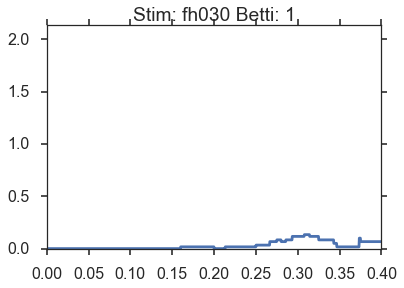

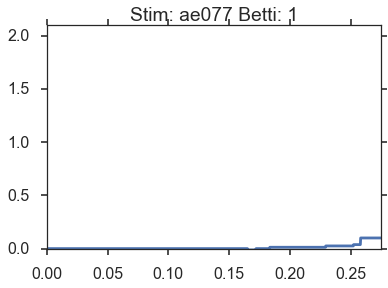

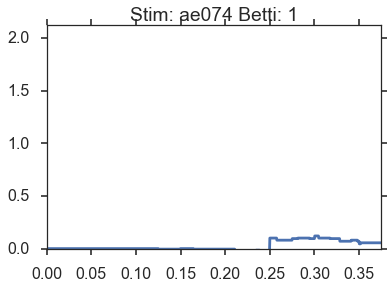

KeyboardInterrupt: 

In [12]:
sns.set_style('ticks')

#plotEvidenceAverageBettiDifference(results, 1)
stims = results.keys()
for stim in stims:
    (avgB, t, maxT) = computeAvgBettiCurve(results, stim, 1, 25.0)
    (avgBs, ts, maxTs) = computeAvgBettiCurve(resultsSh, stim, 1, 25.0)
    plotAvgBettiCurves(avgB - avgBs, t, 1, stim)
    

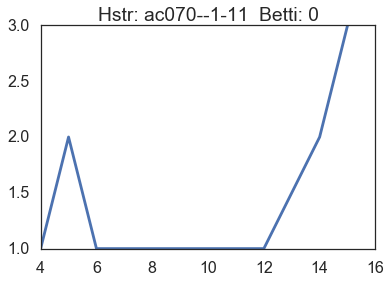

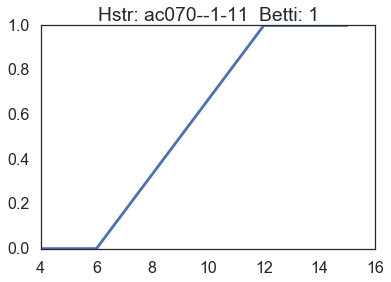

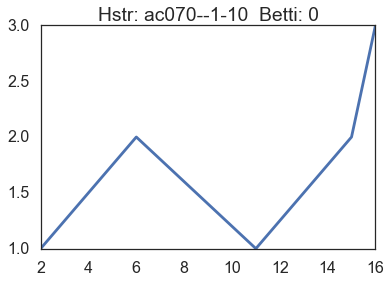

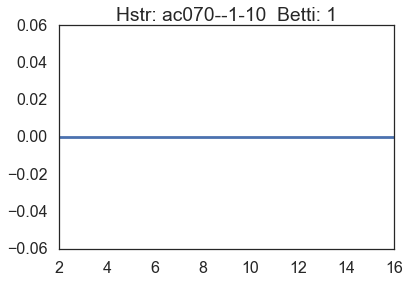

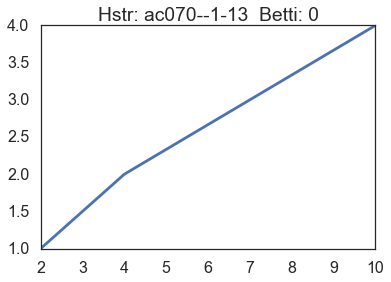

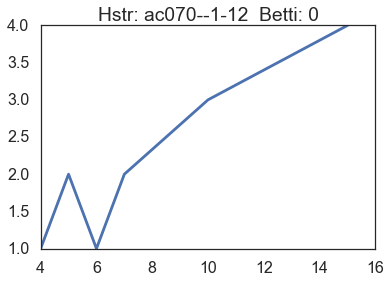

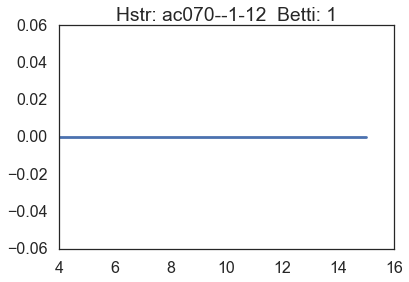

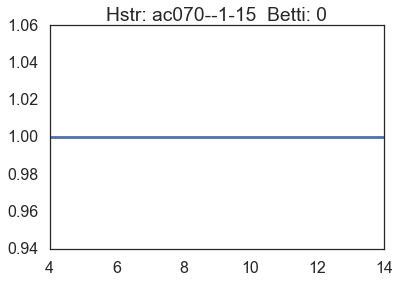

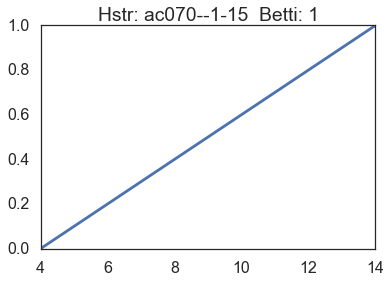

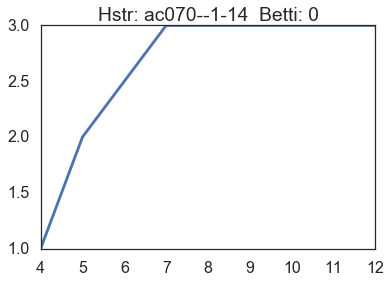

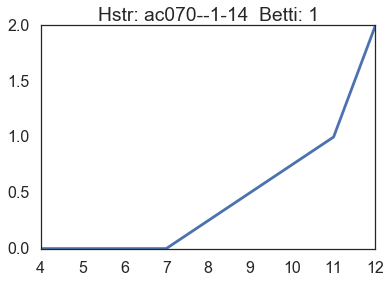

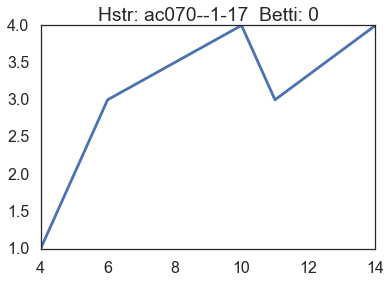

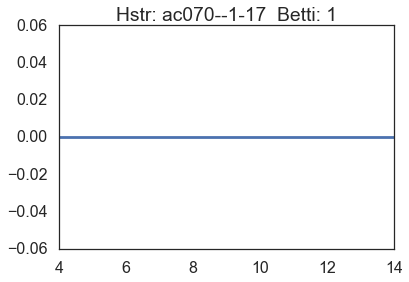

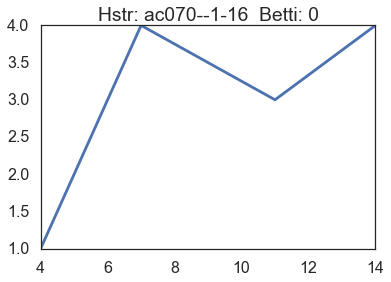

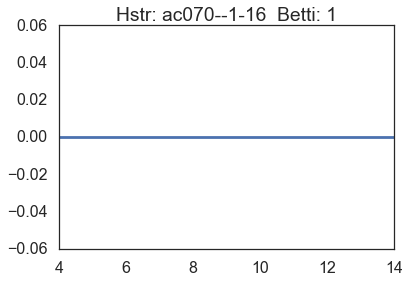

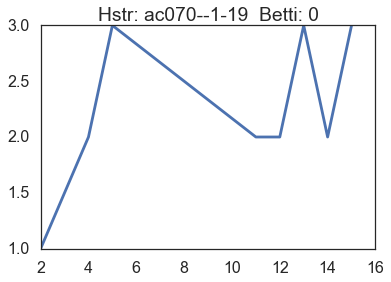

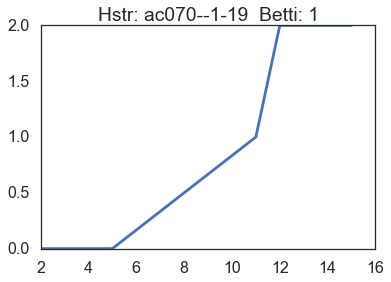

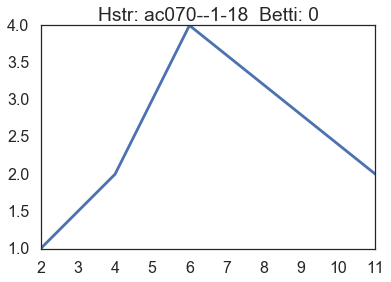

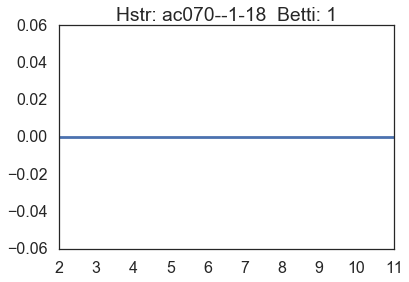

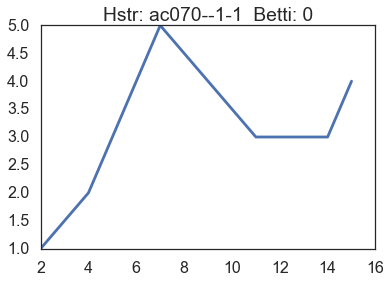

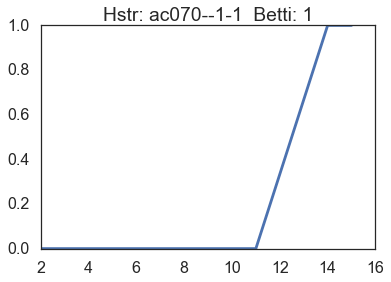

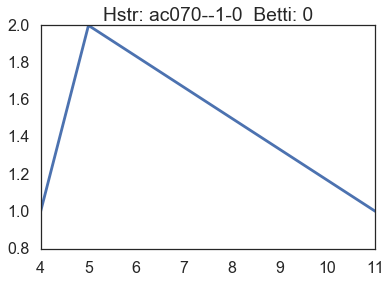

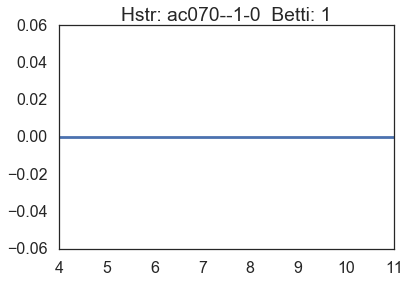

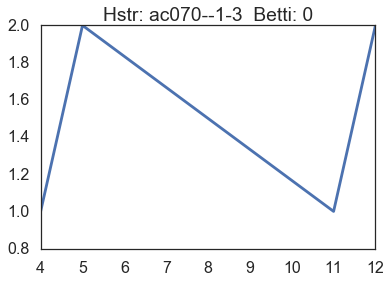

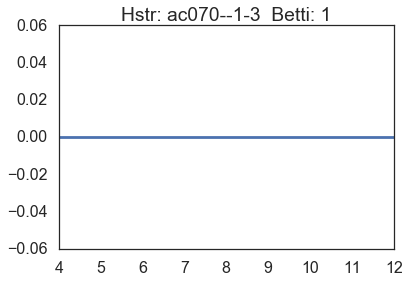

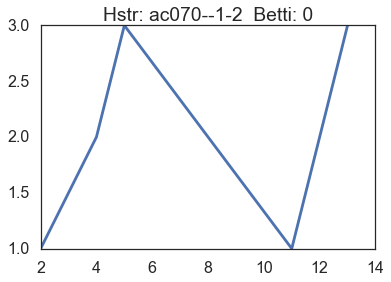

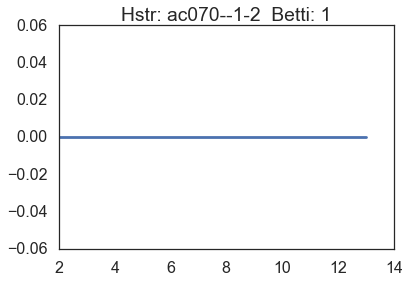

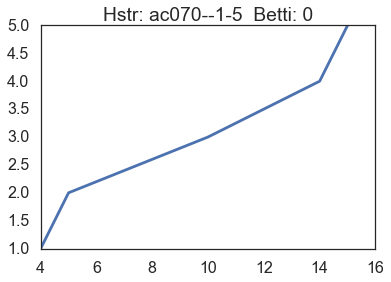

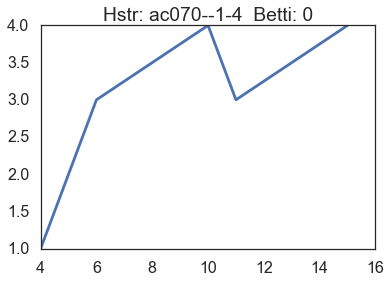

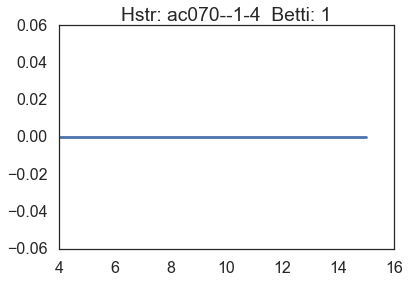

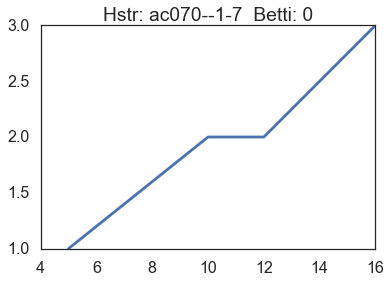

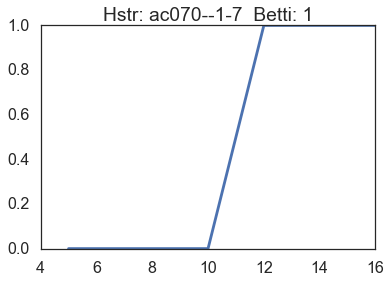

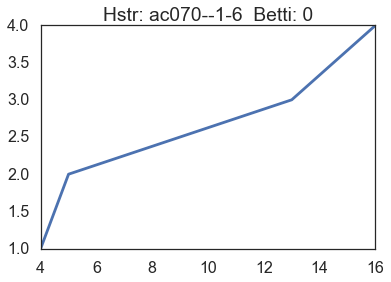

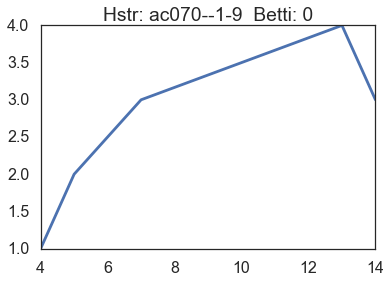

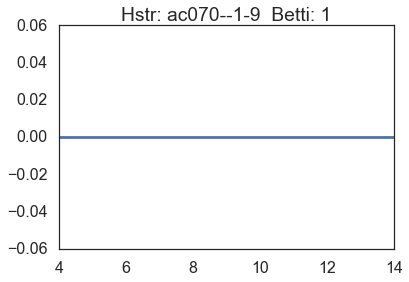

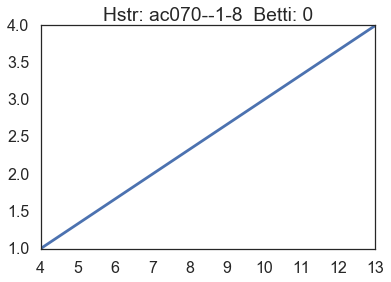

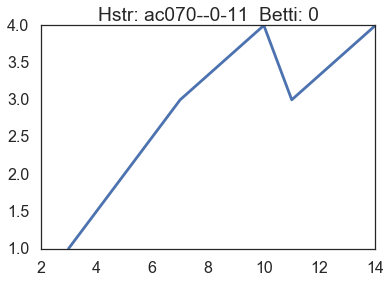

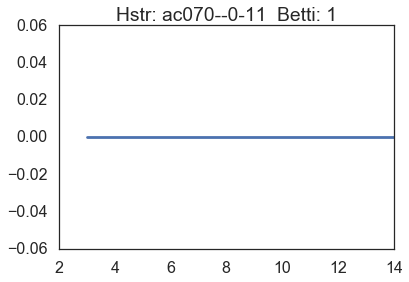

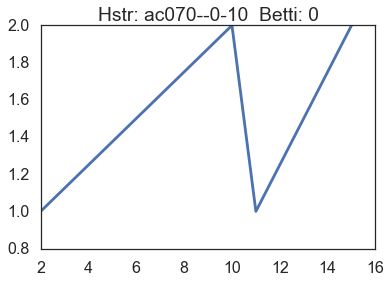

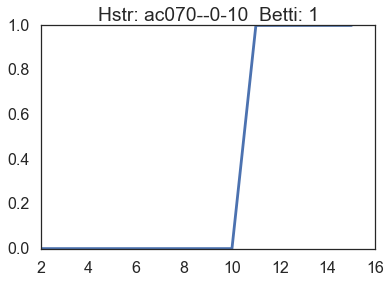

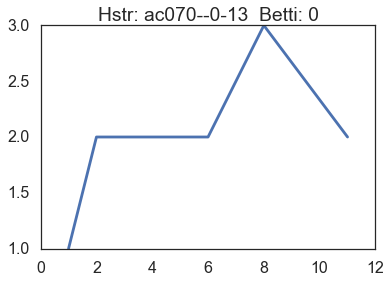

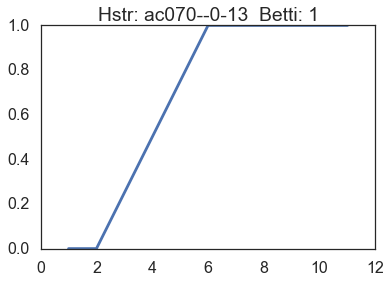

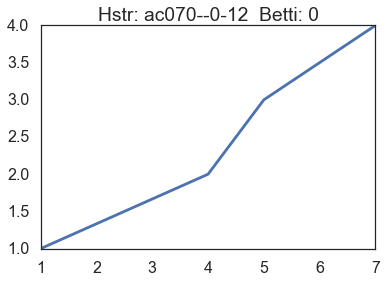

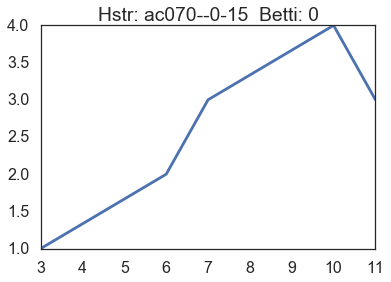

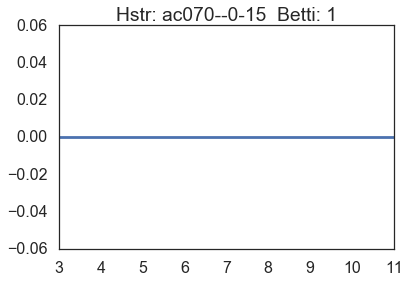

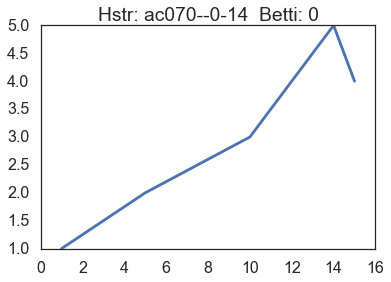

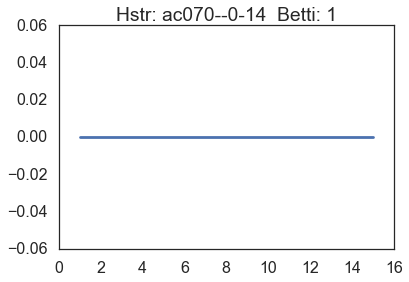

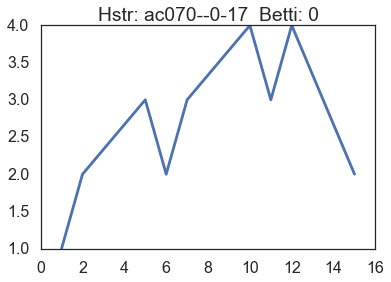

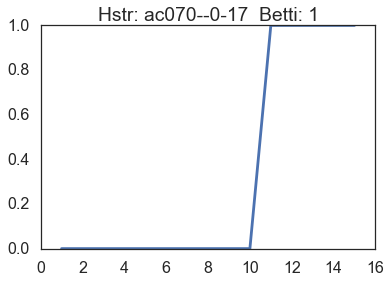

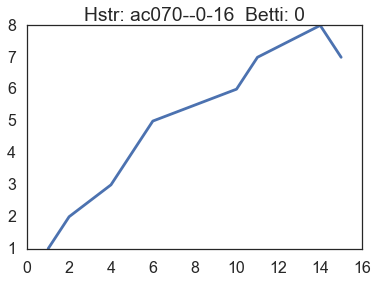

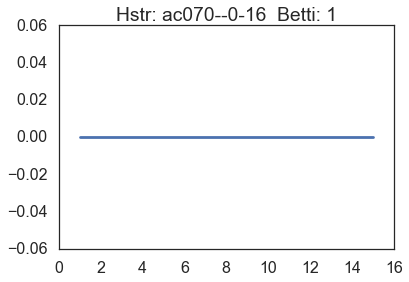

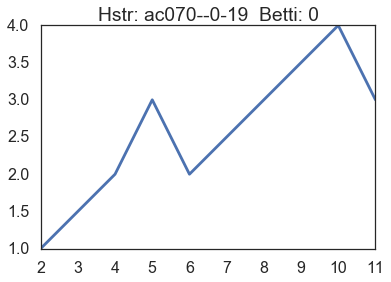

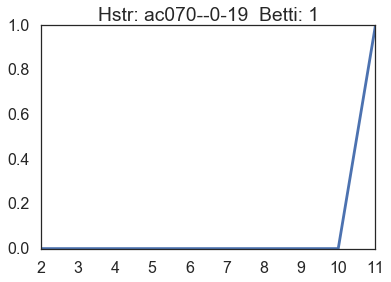

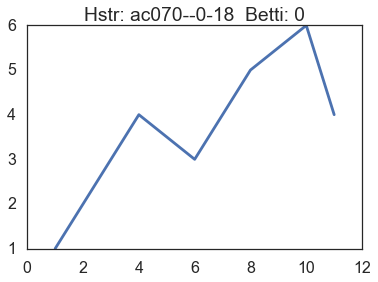

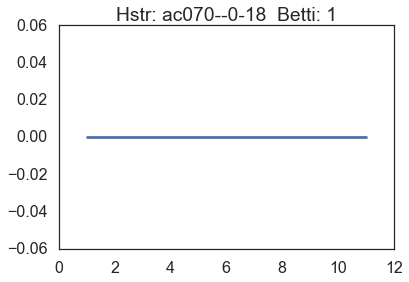

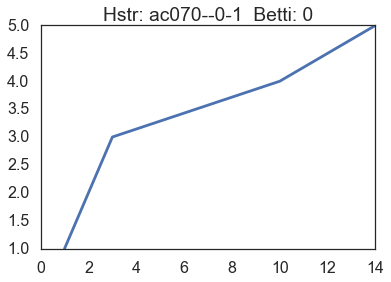

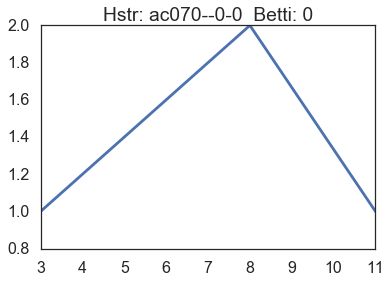

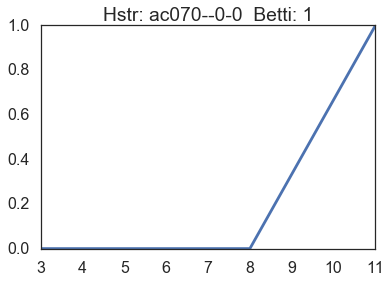

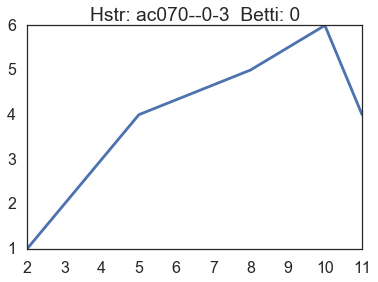

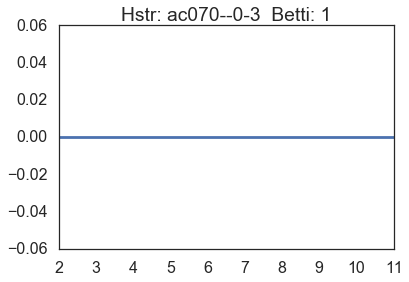

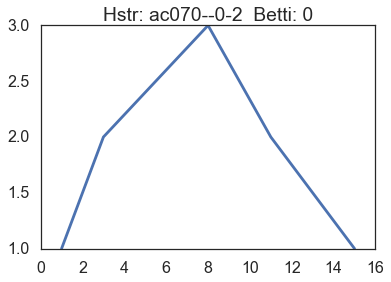

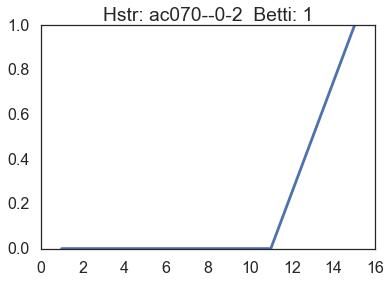

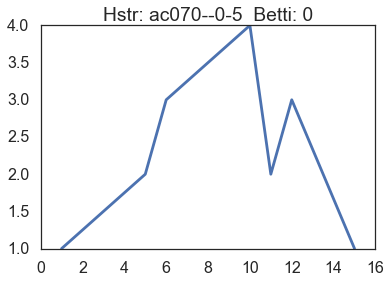

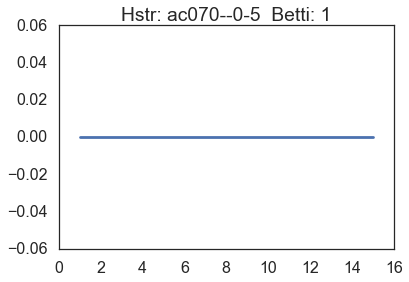

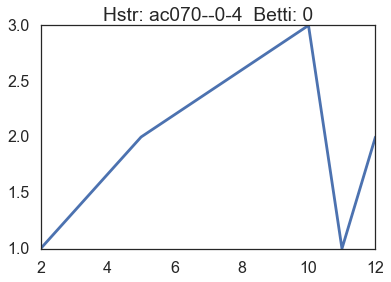

KeyboardInterrupt: 

In [5]:
plotAvgBettiCurves(results)

In [ ]:
tst = np.array()
